# Lab 5 - our own Large (or not that large) Language Model (LLM)

In this lab, we will build our own Large Language Model (LLM) from scratch … or, to be precise, a highly simplified version that will allow us to understand the basics without requiring enormous computational resources or massive datasets.

We will of course use the transformer architecture, which we introduced in the previous class. But first, let’s go through some important concepts.


What is a Language Model (LM)?

A language model is a probabilistic model that operates on sequences of words or characters and predicts the next word or character in a sequence based on the previous ones. Language models are used in many natural language processing (NLP) applications, such as machine translation, speech recognition, text generation, and many others.

In recent years, transformer-based language models have achieved remarkable results across a wide range of NLP tasks. These models are trained on massive text datasets and are capable of generating and understanding long and coherent texts.

In this lab, however, we will focus on two main types of transformer-based language models:
1. **Autoregressive Model**: This type of model generates text sequentially, predicting the next word based on the previous ones. An example is GPT (Generative Pre-trained Transformer), developed primarily by OpenAI. Autoregressive models are often used for tasks such as text generation, machine translation, and text completion.
2. **Masked Language Model**: This type of model is trained to predict missing words in a sentence, where some words are “masked” (hidden). A well-known example is BERT (Bidirectional Encoder Representations from Transformers), developed by Google. Masked models are often used for tasks such as text classification, sentiment analysis, and question answering.


How do these two models differ?

The simplest difference lies in their architecture. Autoregressive models typically consist only of decoders, while masked models consist only of encoders. Of course, there are also hybrid approaches, such as T5 (Text-to-Text Transfer Transformer) and BART (Bidirectional and Auto-Regressive Transformers), which combine features of both. However, for the purpose of this lab, we will focus on the pure implementations.

In autoregressive models (e.g. GPT), the decoder is trained to predict the next word in a sequence based on all previous words. To achieve this, masking is applied to prevent the decoder from accessing future words during training (causal masking, which we discussed in the previous class). During text generation, the model produces words one by one, using its previously generated output as context.

In masked language models (e.g. BERT), the encoder is trained to predict masked words in a sentence by using context from both the left and the right. During training, some words are randomly masked, and the model learns to predict them based on the remaining words. Masked models are generally used for tasks that require understanding the full context of a sentence or document.

<img src=https://raw.githubusercontent.com/vision-agh/DNN-Course-media/refs/heads/main/lab4_5_transformer/figures/gpt_vs_bert.png width=600>

Although, based on what we have learned so far, we could implement both types of models, in this lab we will focus on the autoregressive model. It is more intuitive, easier to understand for beginners, and more interesting in the context of text generation.

For those interested, I encourage you to explore and experiment with masked models such as BERT to broaden your knowledge of different language model architectures. For example, you can follow this tutorial: [link](https://medium.com/@adnanmasood/a-tiny-bert-style-model-from-scratch-a-detailed-exploration-5bc47d59bff5).

Finally, the code below is partly adapted from this tutorial: [link](https://www.youtube.com/watch?v=kCc8FmEb1nY) and original paper [Attention is All You Need](https://arxiv.org/abs/1706.03762).


## Import and Setup

As usual, we start by importing the necessary libraries and setting up the device.

In [3]:
!pip install PyMuPDF

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os, glob

from typing import Optional

import wandb

!wandb login 2f4725bbec8770a63ad5cb3e1ff15f1e53b756f6  # Log in to your W&B account

torch.manual_seed(42)  # For reproducibility

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 81.0 MB/s eta 0:00:00
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
Using device: cuda


Since we are going to implement an autoregressive model, we will need to initialize and use the following components:

1. `PositionalEncoding` class – for adding positional information to the input embeddings.
2. `make_causal_mask` function - for creating a causal mask that prevents the model from attending to future tokens during training.
3. `Head`, `MultiHeadAttention` and `DecoderBlock` classes - for constructing the architecture.

If we prepared part1 correctly, we can simply import these components directly from part1.ipynb.

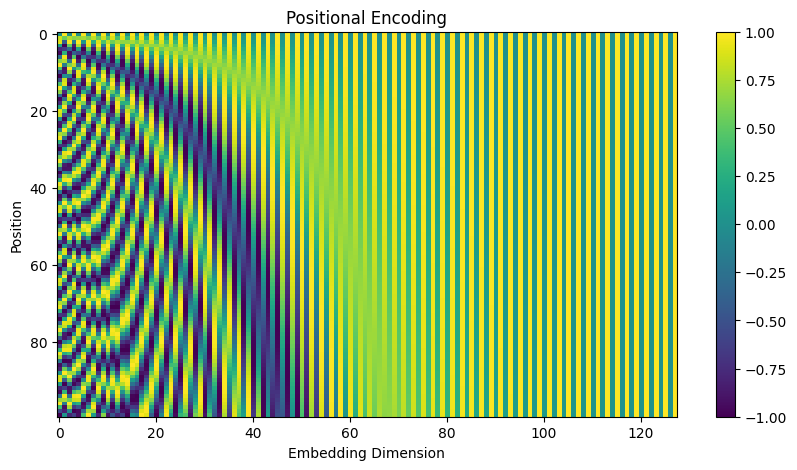

In [4]:
# --- Positional Encoding ---
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer("pe", pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

# Visualization of Positional Encoding
def plot_positional_encoding(pe, max_len=200):
    plt.figure(figsize=(10, 5))
    plt.imshow(pe.pe[0, :max_len].cpu(), cmap='viridis', aspect='auto')
    plt.colorbar()
    plt.xlabel('Embedding Dimension')
    plt.ylabel('Position')
    plt.title('Positional Encoding')
    plt.show()

# Example usage and visualization
d_model = 128
pe = PositionalEncoding(d_model)
plot_positional_encoding(pe, max_len=100)

In [5]:
# --- Single Attention Head ---
class Head(nn.Module):
    def __init__(self, emb_size, head_size, dropout=0.0, bias=False):
        super().__init__()
        self.key   = nn.Linear(emb_size, head_size, bias)
        self.query = nn.Linear(emb_size, head_size, bias)
        self.value = nn.Linear(emb_size, head_size, bias)
        self.scale = 1/math.sqrt(head_size)
        self.dropout = nn.Dropout(dropout)
        self.attn_weights = None

    def forward(self, q, k, v, mask=None):
        Q = self.query(q)
        K = self.key(k)
        V = self.value(v)
        return self.scaled_dot_product_attention(Q, K, V, mask)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        scores = torch.matmul(Q, K.transpose(-2, -1)) * self.scale
        if mask is not None:
            mask.to(device)
            scores = scores.masked_fill(mask==0, float('-inf'))
        attn = F.softmax(scores, dim=-1)
        self.attn_weights = attn.detach().cpu()
        attn = self.dropout(attn)
        out = torch.matmul(attn, V)
        return out

In [6]:
# --- Multi-Head Attention ---
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size, num_heads, dropout=0.0, bias=False):
        super().__init__()
        assert emb_size % num_heads == 0
        head_size = emb_size // num_heads
        self.heads = nn.ModuleList([Head(emb_size, head_size, dropout=dropout, bias=bias) for _ in range(num_heads)])
        self.linear = nn.Linear(head_size * num_heads, emb_size, bias)
        self.dropout = nn.Dropout(dropout)

    def forward(self, q, k, v, mask=None):
        out = torch.cat([head(q, k, v, mask) for head in self.heads], -1)
        out = self.linear(out)
        return self.dropout(out)

    def get_attention_maps(self):
        return [h.attn_weights for h in self.heads if h.attn_weights is not None]

In [7]:
# --- Decoder Block ---
class DecoderBlock(nn.Module):
    def __init__(self, emb_size, num_heads, dropout=0.0, expansion=4, use_cross_attn=False, bias=False):
        super().__init__()
        self.cross_attn = None
        self.self_attn = MultiHeadAttention(emb_size, num_heads, dropout)
        self.norm1 = nn.LayerNorm(emb_size)
        if use_cross_attn:
            self.cross_attn = MultiHeadAttention(emb_size, num_heads, dropout)
            self.norm2 = nn.LayerNorm(emb_size)
        self.norm3 = nn.LayerNorm(emb_size)
        self.ff = nn.Sequential(
            nn.Linear(emb_size, expansion * emb_size), nn.ReLU(), nn.Linear(emb_size * expansion, emb_size)
        )

    def forward(self, x,
                enc_out: Optional[torch.Tensor]=None,
                tgt_mask: Optional[torch.Tensor]=None):

        if (self.cross_attn is None or self.cross_attn is False) and enc_out is not None:
            raise ValueError("Cross-attention is not enabled in this DecoderBlock.")

        self_attn_out = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self_attn_out)

        if enc_out is not None:
            cross_attn_out = self.cross_attn(x, enc_out, enc_out)
            x = self.norm2(x + cross_attn_out)

        ff_out = self.ff(x)
        x = self.norm3(x + ff_out)
        return x

In [8]:
def make_causal_mask(seq_len):
    return torch.tril(torch.ones(seq_len, seq_len)).unsqueeze(0)

## Now let's implement our own autoregressive Mini-GPT model

We will now implement our own autoregressive Mini-GPT model using the components we have prepared earlier.

Compared to our previous Transformer implementation, this model introduces one additional parameter — `block_size`, which defines the maximum sequence length that the model can handle. This parameter is crucial for autoregressive models because it determines how many previous tokens the model can consider when predicting the next one.

If we allowed the model to use all previous tokens without any limit, we could quickly run into memory issues, especially for long sequences. The `block_size` acts as a sliding context window to keep computation and memory manageable.

#### Text generation with generate()

We will also implement a generate() method for text generation. This method will allow the model to produce text autoregressively — one token at a time — starting from an initial input sequence.

In addition, we will use a `temperature` parameter to control the randomness of the predictions.
- A higher `temperature` results in more random and creative outputs.
- A lower `temperature` makes the model’s predictions more focused and deterministic.

> How does it work?
> Once we obtain the model’s output logits, we can convert them into probabilities using the softmax function. The temperature is applied by dividing the logits by the temperature value before softmax.

After obtaining the probability distribution, we sample from it to select the next token.

For example, if the logits for the next token are [2.0, 1.0, 0.1] and the temperature is set to 0.5, the scaled logits become [4.0, 2.0, 0.2].
Applying softmax to these scaled values results in a probability distribution that is more concentrated on the highest value — making it more likely that the token corresponding to the largest logit will be selected.

- `__init_`:
    - Initializes the parameter `block_size`.
    - Initializes token and positional embeddings.
    - Creates a list of decoder blocks (note that `use_cross_attn=False`, since we use only the decoder architecture).
    - Adds a final linear layer to project the decoder output to the vocabulary size.

- `forward`:
    Similar to the previous Transformer implementation:
    1. The input sequence `src` is passed through the embedding layer, positional encoding, and then through the decoder blocks. Since this is a decoder-only model, we use a `causal mask` and set `enc_out=None`.
    2. The output is projected to the vocabulary dimension using the final linear layer.
    3. We compute the cross-entropy loss inside the model for convenience.
        - If `targets` is None, the loss is set to None.
        - Otherwise, the predicted logits and target tokens are reshaped to match the expected format for `F.cross_entropy`:
            - `logits` -> shape `(batch_size * seq_len, vocab_size)`
            - `targets` -> shape `(batch_size * seq_len)`
    4. The forward() method returns both the logits and the loss.

- `generate`:
    This method generates text autoregressively.
    1. It takes an initial input sequence `src` and generates `max_new_tokens` additional tokens.
    2. For each iteration:
        - Slice the input to ensure it does not exceed `block_size` (src[:, -self.block_size:] works even when shorter).
        - Create a causal mask for the current sequence length.
        - Pass the current input and mask to the model to obtain logits.
        - Extract the logits for the last token in the sequence (`logits[:, -1, :]`) and divide them by the temperature to adjust randomness.
        - If `top_k` is specified, apply top-k filtering to keep only the top `k` most likely tokens, setting the rest to negative infinity:

            ```python
            v, _ = torch.topk(logits, top_k)
            logits[logits < v[:, [-1]]] = -float('Inf')
            ```
        - Apply softmax to obtain a probability distribution over the vocabulary.
        - Sample the next token from this distribution using `torch.multinomial`.
        - Concatenate the sampled token to `src` for the next iteration.
    3. Finally, the method returns the extended sequence containing both the original and generated tokens.    

In [9]:
# --- MiniGPT model ---
class MiniGPT(nn.Module):
    def __init__(self, voc_size, emb_size=64, num_heads=2, num_layers=1, block_size=32, use_cross_attn=False):
        super().__init__()
        self.block_size = block_size
        self.token_emb = nn.Embedding(voc_size, emb_size)
        self.pos_emb = PositionalEncoding(emb_size)

        self.blocks = nn.ModuleList([DecoderBlock(emb_size, num_heads, use_cross_attn=False) for _ in range(num_layers)])
        self.fc_out = nn.Linear(emb_size, voc_size)

    def forward(self, src, targets=None, mask=None):
        src = self.pos_emb(self.token_emb(src))
        for block in self.blocks:
            src = block(src, enc_out=None, tgt_mask=mask)
        logits = self.fc_out(src)
        if targets is None:
            return logits, None
        else:
            B, T, C = logits.shape  # batch_size, seq_len, vocab_size
            logits = torch.reshape(logits, (B * T, C))
            targets = torch.reshape(targets, (B * T,))
            loss = F.cross_entropy(logits, targets)
            return logits, loss

    def generate(self, src, max_new_tokens, temperature=1.0, top_k=None):
        for _ in range(max_new_tokens):
            # 1. Loop for the number of new tokens to generate
            src_cut = src[:, -self.block_size:]  # 2. Crop src to the last block_size tokens
            T = src_cut.size(1)  # 3. Get the current sequence length T
            mask = make_causal_mask(T).to(src.device)  # 4. Create a causal mask for the current sequence length T
            logits, _ = self.forward(src_cut, mask=mask)  # 5. Forward pass through the model to get logits
            logits = logits[:, -1, :] / temperature  # 6. Focus on the last time step and apply temperature scaling
            if top_k is not None:  # 7. If top_k is specified, filter logits to keep only the top_k highest values
                v, _ = torch.topk(logits, top_k)  #    - Get the top_k values and their indices
                logits[logits < v[:, [-1]]] = -float('Inf')  #    - Set logits below the top_k threshold to -Inf
            probs = F.softmax(logits, dim=-1)  # 8. Apply softmax to obtain a probability distribution over the vocabulary
            next_token = torch.multinomial(probs, num_samples=1)  # 9. Sample the next token from this distribution using torch.multinomial
            src = torch.cat((src, next_token), dim=1)  # 10. Concatenate the sampled token to src for the next iteration
        return src

Now that we have our model implemented, we can proceed to prepare the dataset and train it on some text data. We could use any publicly available text dataset already prepared for language modeling, but that would be too easy. Instead, we’ll create our own small dataset based on the poems of Adam Mickiewicz, one of the greatest Polish poets.

Although the dataset will be relatively small, it should be sufficient for our educational purposes. It will consist of the following works:

1. "Pan Tadeusz"
2. "Dziady" part II
3. "Dziady" part III
3. "Dziady" part IV

All these poems are available in PDF format from [Wolne Lektury](https://wolnelektury.pl/katalog/autor/adam-mickiewicz/). To read the PDFs and extract the text, we will use the PyMuPDF library (you need to install it if you do). To remove unnecessary content such as prefaces, introductions, and appendices, we will skip the first and last pages of each PDF document.

Since the texts are in Polish, we must also ensure that our tokenizer correctly handles Polish characters. In some PDFs, Polish letters may be read incorrectly due to encoding issues, so we may need to remap them from UTF-8 to Latin-1. Additionally, we will remove page numbers and any other extraneous elements.

To generate the dataset, we will extract the text from the PDFs, clean it by removing unwanted characters and lines, and concatenate all the content into a single string. This text will then serve as the input for creating a custom dataset to train our Mini-GPT model.

Of course, you could use different text data in any language, but I encourage you to try this approach with other works as well. Just make sure the text is in the public domain or that you have the right to use it for your experiments.

In [12]:
from google.colab import files
# uploaded = files.upload()

Saving dziady2.pdf to dziady2.pdf
Saving dziady3.pdf to dziady3.pdf
Saving dziady4.pdf to dziady4.pdf
Saving tadeusz.pdf to tadeusz.pdf


In [13]:
import fitz

def read_pdf_fixed(path):
    doc = fitz.open(path)
    text = ""
    for page in doc[1:-1]:                  # skip first and last page
        page_text = page.get_text("text")
        if page_text:
            text += page_text + "\n"

    # mapping of bad characters to good ones
    mapping = {
        "Ê": "Ę", "ê": "ę",
        "Œ": "Ś", "œ": "ś",
        "³": "ł", "£": "Ł",
        "¯": "Ż", "¿": "ż",
        "Ÿ": "Ź", "ÿ": "ź",
        "ñ": "ń", "Ñ": "Ń",
        "¹": "ą", "¡": "Ą",
        "æ": "ć", "Æ": "Ć",
        "¢": "ó",
    }

    # replace bad characters
    for bad, good in mapping.items():
        text = text.replace(bad, good)

    lines = text.splitlines()
    cleaned = []
    for line in lines:
        if line.strip().isdigit():          # remove page numbers
            continue
        cleaned.append(line)                # append cleaned line

    return "\n".join(cleaned)               # return cleaned text


# --- Read and clean text from multiple PDF files ---
text = ""
for file in ["/content/tadeusz.pdf", "/content/dziady2.pdf", "/content/dziady3.pdf", "/content/dziady4.pdf"]:
    text += read_pdf_fixed(file) + "\n"


# --- Print a snippet of the cleaned text and its length ---

print(text[:1000])
print("-" * 20)
print("Size of the text:", len(text))

KSIĘGA PIERWSZA
Gospodarstwo
Powrót panicza — Spotkanie się pierwsze w pokoiku, drugie u stołu — Ważna
Sędziego nauka o grzeczności — Podkomorzego uwagi polityczne nad modami
— Początek sporu o Kusego i Sokoła — Żale Wojskiego — Ostatni Woźny
Trybunału — Rzut oka na ówczesny stan polityczny Litwy i Europy
Litwo! Ojczyzno moja! ty jesteś jak zdrowie:
Ile cię trzeba cenić, ten tylko się dowie,
Kto cię stracił. Dziś piękność twą w całej ozdobie
Widzę i opisuję, bo tęsknię po tobie.
Panno święta, co Jasnej bronisz Częstochowy
I w Ostrej świecisz Bramie! Ty, co gród zamkowy
Nowogródzki ochraniasz z jego wiernym ludem!
Jak mnie dziecko do zdrowia powróciłaś cudem
(Gdy od płaczącej matki, pod Twoją opiekę
Ofiarowany, martwą podniosłem powiekę;
I zaraz mogłem pieszo, do Twych świątyń progu
Iść za wrócone życie podziękować Bogu),
Tak nas powrócisz cudem na Ojczyzny łono.
Tymczasem przenoś moją duszę utęsknioną
Do tych pagórków leśnych, do tych łąk zielonych,
Szeroko nad błękitnym Niemnem rozcią

### Hyperparameters and Data Preparation

In this part, we define the main hyperparameters and prepare the dataset for training our Mini-GPT model.

First, we set parameters such as the batch size, embedding dimension, number of attention heads and layers, and the `block_size`, which defines how many previous tokens the model can see when predicting the next one.

Next, we create functions to **encode** text into integers and **decode** integers back into text.  
We also build our vocabulary by finding all unique characters in the dataset.

Then, we split the data into **training** and **validation** sets (90% / 10%).

Finally, we define the `get_batch()` function, which randomly selects short sequences of tokens from the dataset.  
For each batch:
- `src` is the input sequence,  
- `tgt` is the same sequence shifted one step ahead, so the model learns to predict the next token.


In [14]:
# --- Hyperparameters ---

batch_size = 16         # how many independent sequences will we process in parallel?
emb_size = 128          # embedding dimension for each token ()
num_heads = 8           # number of attention heads in each decoder block
num_layers = 6          # number of decoder blocks
block_size = 64         # maximum context length for predictions

learning_rate = 1e-3    # learning rate
max_iters = 5000        # number of training iterations
eval_interval = 50      # interval for evaluation
eval_iters = 200        # number of iterations for evaluation

# --- Prepare the encode/decode functions ---

uniq_chars = sorted(list(set(text)))            # get all unique characters that occur in this text
vocab_size = len(uniq_chars)                    # the size of the vocabulary

char2idx = { ch:i for i,ch in enumerate(uniq_chars) }       # mapping from characters to integers
idx2char = { i:ch for i,ch in enumerate(uniq_chars) }       # mapping from integers to characters

encode = lambda seq: [char2idx[c] for c in seq]             # encoder: take a string, output a list of integers
decode = lambda seq: ''.join([idx2char[i] for i in seq])    # decoder: take a list of integers, output a string

# --- Prepare the dataset ---

data = torch.tensor(encode(text), dtype=torch.long)         # encode the entire text dataset and store it in a torch.Tensor
split = int(0.9*len(data))
train_data, val_data = data[:split], data[split:]           # split the data into train and validation sets

# --- Function to get a batch of data ---
def get_batch(split):
    data = train_data if split == 'train' else val_data             # choose the dataset
    ix = torch.randint(0, len(data) - block_size, (batch_size,))    # random starting indices for the batch (from 0 to len(data) - block_size)
    src = data[ix.unsqueeze(1) + torch.arange(block_size)]          # get the sequences of length block_size for each index in the batch
    tgt = data[ix.unsqueeze(1) + torch.arange(1, block_size + 1)]   # targets are the same as src but shifted by one position
    return src, tgt

src, tgt = get_batch('train')

print(src[0])
print(tgt[0])

print("-" * 20)

print(decode(src[0].tolist()))
print(decode(tgt[0].tolist()))

tensor([ 1, 66, 52, 47, 69, 52, 62, 69,  1, 58, 61, 87, 68,  1, 69, 87, 58, 63,
        48,  6,  1, 62, 61, 48, 45, 61, 57, 48, 16,  1, 50, 47, 68,  1, 63, 61,
        85, 45, 44, 46, 69, 48,  0, 32, 58, 45, 64, 47, 54, 85,  1, 27, 58, 90,
        46, 52, 64, 62, 69, 54, 58, 66, 62, 54])
tensor([66, 52, 47, 69, 52, 62, 69,  1, 58, 61, 87, 68,  1, 69, 87, 58, 63, 48,
         6,  1, 62, 61, 48, 45, 61, 57, 48, 16,  1, 50, 47, 68,  1, 63, 61, 85,
        45, 44, 46, 69, 48,  0, 32, 58, 45, 64, 47, 54, 85,  1, 27, 58, 90, 46,
        52, 64, 62, 69, 54, 58, 66, 62, 54, 81])
--------------------
 widzisz orły złote, srebrne? gdy trębacze
Pobudkę Kościuszkowsk
widzisz orły złote, srebrne? gdy trębacze
Pobudkę Kościuszkowską


### Model Initialization and Training Setup

Here we create an instance of our **Mini-GPT** model and prepare the optimizer and learning rate scheduler.

- The model is initialized with the vocabulary size and hyperparameters defined earlier, then moved to the selected device (CPU or GPU).
- We use the **AdamW** optimizer, which is well-suited for training transformer-based models due to its weight decay regularization.
- A **Cosine Annealing** learning rate scheduler gradually decreases the learning rate over time (`T_max = max_iters`), helping the model converge more smoothly during training.


In [15]:
model = MiniGPT(vocab_size, emb_size, num_heads, num_layers, block_size).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_iters)

In [16]:
class Trainer():
    def __init__(self,
                 model,
                 optimizer,
                 scheduler,
                 get_batch,
                 make_causal_mask,
                 device,
                 max_iters=5000,
                 eval_interval=50,
                 eval_batches=10,          # number of batches to average during evaluation
                 name="Roman Nowak"):

        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.get_batch = get_batch
        self.make_causal_mask = make_causal_mask
        self.device = device
        self.max_iters = max_iters
        self.eval_interval = eval_interval
        self.eval_batches = eval_batches
        self.name = name
        self.best_val_loss = float('inf')

    def training_step(self):
        """Perform one training step on a randomly sampled batch."""
        self.model.train()
        src, target = self.get_batch('train')
        mask = self.make_causal_mask(src.size(1))

        src, target, mask = src.to(self.device), target.to(self.device), mask.to(self.device)

        logits, loss = self.model(src, target, mask)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.scheduler.step()

        return loss.item()

    def evaluate(self):
        """Evaluate model performance on multiple validation batches."""
        self.model.eval()
        total_loss = 0.0

        with torch.no_grad():
            for _ in range(self.eval_batches):
                src, target = self.get_batch('val')
                mask = self.make_causal_mask(src.size(1))
                src, target, mask = src.to(self.device), target.to(self.device), mask.to(self.device)

                _, val_loss = self.model(src, target, mask)
                total_loss += val_loss.item()

        avg_loss = total_loss / self.eval_batches
        return avg_loss

    def train(self):
        """Main training loop with Weights & Biases logging and model checkpointing."""
        wandb.init(
            project="lab5-mini-gpt",
            entity="deep-neural-network-course",
            group="mini-gpt",
            name=self.name,
            settings=wandb.Settings(save_code=False)
        )
        wandb.watch(self.model, log="all")

        for step in range(self.max_iters):
            train_loss = self.training_step()
            wandb.log({"train/loss": train_loss, "lr": self.scheduler.get_last_lr()[0]}, step=step)

            if step % self.eval_interval == 0:
                val_loss = self.evaluate()
                wandb.log({"val/loss": val_loss}, step=step)
                print(f"Step [{step}/{self.max_iters}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

                # Save best model
                if val_loss < self.best_val_loss:
                    self.best_val_loss = val_loss
                    torch.save(self.model.state_dict(), "best_mini_gpt.pth")
                    print(f"New best model saved (Val Loss: {self.best_val_loss:.4f})")

        wandb.unwatch(model)
        wandb.finish()

trainer = Trainer(model, optimizer, scheduler, get_batch, make_causal_mask, device, max_iters, eval_interval)

In [17]:
trainer = Trainer(
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    get_batch=get_batch,
    make_causal_mask=make_causal_mask,
    device=device,
    max_iters=max_iters,
    eval_interval=eval_interval,
    name="Roman Nowak"
)

trainer.train()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Currently logged in as: romannowak9 (romannowak9-agh) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step [0/5000], Train Loss: 4.6486, Val Loss: 3.9970
New best model saved (Val Loss: 3.9970)
Step [50/5000], Train Loss: 2.6476, Val Loss: 2.6687
New best model saved (Val Loss: 2.6687)
Step [100/5000], Train Loss: 2.6521, Val Loss: 2.6208
New best model saved (Val Loss: 2.6208)
Step [150/5000], Train Loss: 2.5280, Val Loss: 2.5526
New best model saved (Val Loss: 2.5526)
Step [200/5000], Train Loss: 2.4616, Val Loss: 2.5170
New best model saved (Val Loss: 2.5170)
Step [250/5000], Train Loss: 2.4805, Val Loss: 2.4927
New best model saved (Val Loss: 2.4927)
Step [300/5000], Train Loss: 2.3963, Val Loss: 2.4331
New best model saved (Val Loss: 2.4331)
Step [350/5000], Train Loss: 2.3678, Val Loss: 2.3811
New best model saved (Val Loss: 2.3811)
Step [400/5000], Train Loss: 2.3956, Val Loss: 2.3692
New best model saved (Val Loss: 2.3692)
Step [450/5000], Train Loss: 2.2401, Val Loss: 2.2898
New best model saved (Val Loss: 2.2898)
Step [500/5000], Train Loss: 2.2655, Val Loss: 2.3114
Step [550

lr,███████▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▂▂▂▂▂▁▁▁▁▁
train/loss,█▆▆▅▄▄▄▃▃▃▃▂▃▂▃▂▂▂▂▂▂▂▁▁▁▂▁▁▂▂▁▂▁▁▁▁▂▁▁▁
val/loss,█▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,0
train/loss,1.53303
val/loss,1.74955


In [18]:
# generate from the model
model.load_state_dict(torch.load("best_mini_gpt.pth"))
context = torch.zeros((1, 1), dtype=torch.long, device=device)
generated = model.generate(context, max_new_tokens=1000, temperature=0.5, top_k=2)[0].tolist()
print(decode(generated))


Pod kontusza się, w przed stolicy w kolanie,
I przed na kontusza się w koniec w pole.
Widzę, że w te pod biegu pod stołu pod koniec,
W koniu przez drzwi się z niebo pod pod kończył,
I pod stolicy na przed szlachtę i przed kończył,
I wiedząc się w niebo przez drugiej przed naszego
I po czasie zapomniał w kolej w koniu i w przed szlachtę i w pokoju.
Tak za nim straszy w pole szalaki się w pokoju.
Widzisz to pod polskiej strach przed niebiosa,
Adam Mickiewicz Pan Tadeusz, czyli ostatni zajazd na Litwie

Podkomorzy przyjaźń w pole wyszli, wiecie,
I po chwali się z przed pokoju, wielkiej służy,
Przy tyle słowach zawsze szlachcica się za się pod słońcem,
I potrzeba się z najwyższej w przechodził,
Podkomorzy w przed polskich na polowania,
I przez kontustów w niebie wielkie po słowo
Podkomorzy pod prosił w konewkie wielkiej stronie,
Podniósł i pod kończył się w przed stracia i krótki,
I zapał na przyjaźnie z dawnymi się w pokoju.
W koniec po trawym się podarło się z pokoleniem,
I przy polskie

In [19]:
input_text = "Litwo! Ojczyzno moja!"
context = torch.tensor(encode(input_text), dtype=torch.long, device=device).unsqueeze(0)
generated = model.generate(context, max_new_tokens=500, temperature=0.7, top_k=10)[0].tolist()
print(decode(generated))

Litwo! Ojczyzno moja!
A co choć wszędzie? — widzisz to pan Rejent cudzowie
Z księdza nimś po często poważnie i skrzywa:
Bo się szyka przybiega, jak biedzie z gorzem.
Miałem konie, szale płoty dobry strony się napoley.
Adam Mickiewicz Dziady, część III


Jeżeli do domu pochwały nie wiem,
A każdy służył, na koniec wybrały w pierwsze,
Krzycząc z powietrze mówił za nim nie wiele.
Ale jej był przy konfederskę kłamie,
Co nas nie uczuła, szczypady na do smerai.
Zamek się nie rusza sądził do niebiosem wieść z pokój?
Jestem,


In [20]:
print("Model architecture:")
print(model)

print("Number of parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad) / 1_000_000, "M")

Model architecture:
MiniGPT(
  (token_emb): Embedding(100, 128)
  (pos_emb): PositionalEncoding()
  (blocks): ModuleList(
    (0-5): 6 x DecoderBlock(
      (self_attn): MultiHeadAttention(
        (heads): ModuleList(
          (0-7): 8 x Head(
            (key): Linear(in_features=128, out_features=16, bias=False)
            (query): Linear(in_features=128, out_features=16, bias=False)
            (value): Linear(in_features=128, out_features=16, bias=False)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (linear): Linear(in_features=128, out_features=128, bias=False)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm3): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (ff): Sequential(
        (0): Linear(in_features=128, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=128, bias=True)
      )
    )
  

As we can see, we now have our own Mini-GPT model capable of generating fairly coherent text in Polish, despite being trained on a small dataset. The model itself is quite compact — with only about **1.2 million parameters**, it can be easily trained on a single GPU.

For comparison, the original GPT-3 model contains around **175 billion parameters**, while GPT-4 is estimated to have about **1.8 trillion parameters** (although during inference it uses only a subset of them thanks to the Mixture of Experts architecture). This highlights just how much smaller and lighter our implementation is.

One potential improvement would be to cache the results of the attention mechanism during text generation. This would allow the model to avoid recomputing attention outputs for all previously generated tokens at each step — a significant optimization for longer sequences. However, for the sake of simplicity, we did not implement this feature here.